In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import cv2 as cv
from skimage.segmentation import slic

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment
import findatree.segmentation2 as segment2

importlib.reload(segment)
importlib.reload(segment2)

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define raster-files and print infos

In [2]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
file_names.extend(['Tnr_12702_D-20210713_DSM.tif'])
file_names.extend(['tnr_12702_dtm.tif'])
file_names.extend(['Tnr_12702_2021_Ortho.tif'])


paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

io.print_raster_info(paths)


(0)
Name: C:/Data/lwf/DSM_2021/Tnr_12702_D-20210713_DSM.tif
Width[px]: 4749
Height[px]: 4626
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-32767.0,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=661774.3636313608, bottom=5470426.000381344, right=662196.9573473627, top=5470837.648840014)
Affine geo-transfrom: [0.08898583196501086, 0.0, 661774.3636313608, 0.0, -0.0889858319649575, 5470837.648840014]

(1)
Name: C:/Data/lwf/DTM/tnr_12702_dtm.tif
Width[px]: 398
Height[px]: 409
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-3.4028234663852886e+38,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=661789.9361519547, bottom=5470428.936913799, right=662187.9361519547, top=5470837.936913799)
Affine geo-transfrom: [1.0, 0.0, 661789.9361519547, 0.0, -1.0, 5470837.936913799]

(2)
Name: C:/Data/lwf/Orthophotos_2021/Tnr_12702_2021_Ortho.tif
Width[px]: 7913
Height[px]: 8617
No. of rasters: 5
  Index: 1, dtype: uint16


### Reproject raster-files to same area & resolution

In [3]:
importlib.reload(io)
res = 0.2
bands, mask, A, bound = io.reproject_all_intersect(paths, res=res)

C:\Users\flori\Anaconda3\envs\findatree_v01\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Define and normalize channels

In [11]:
importlib.reload(io)

cs_prim = {
    'dsm': bands[0][:,:,0],
    'dtm': bands[1][:,:,0],
    'blue': bands[2][:,:,0],
    'red': bands[2][:,:,1],
    'green': bands[2][:,:,2],
    're': bands[2][:,:,3],
    'nir': bands[2][:,:,4],
}

reduce = 2
cs = io.define_channels(cs_prim, reduce=reduce)

res_final = res * 2**reduce
print(f"Resolution of images: {res_final:.1f} m")

Resolution of images: 0.8 m


### Segmentation
#### (1) Global mask and local mask by adaptive gaussian thresholding

In [95]:
importlib.reload(segment2)

# Rough global mask of positives
mask_global = (cs['chm'] > 3) & (cs['ndvi'] > 0.6) & (cs['l'] > 5e-3)

# Local mask of positives by adaptive thresholding
img = cs['l']
distance = 15 / res_final
mask_local = segment2.local_thresholding(img, mask_global, distance)


Distance set to: 19 [px]


#### (2) Normalize color channels within local mask

In [128]:
importlib.reload(segment2)

# Normalize channels within mask
cs_norm = segment2.normalize_channels(
    cs,
    res_xy=0.8,
    res_z=1,
    mask=mask_local,
    percentile=2,
)

Channel: 'blue' from 8.8e-03 to 2.0e-02 mapped to [0,1]
Channel: 'red' from 1.7e-02 to 3.9e-02 mapped to [0,1]
Channel: 'green' from 9.0e-03 to 2.5e-02 mapped to [0,1]
Channel: 're' from 6.5e-02 to 1.9e-01 mapped to [0,1]
Channel: 'nir' from 1.1e-01 to 3.3e-01 mapped to [0,1]
Channel: 'ndvi' from 6.6e-01 to 8.4e-01 mapped to [0,1]
Channel: 'rgb' from 1.1e-02 to 2.6e-02 mapped to [0,1]
Channel: 'h' from 2.1e+02 to 2.5e+02 mapped to [0,1]
Channel: 'l' from 1.3e-02 to 2.9e-02 mapped to [0,1]
Channel: 's' from 2.5e-01 to 4.6e-01 mapped to [0,1]


#### (3) Plot intermediate result

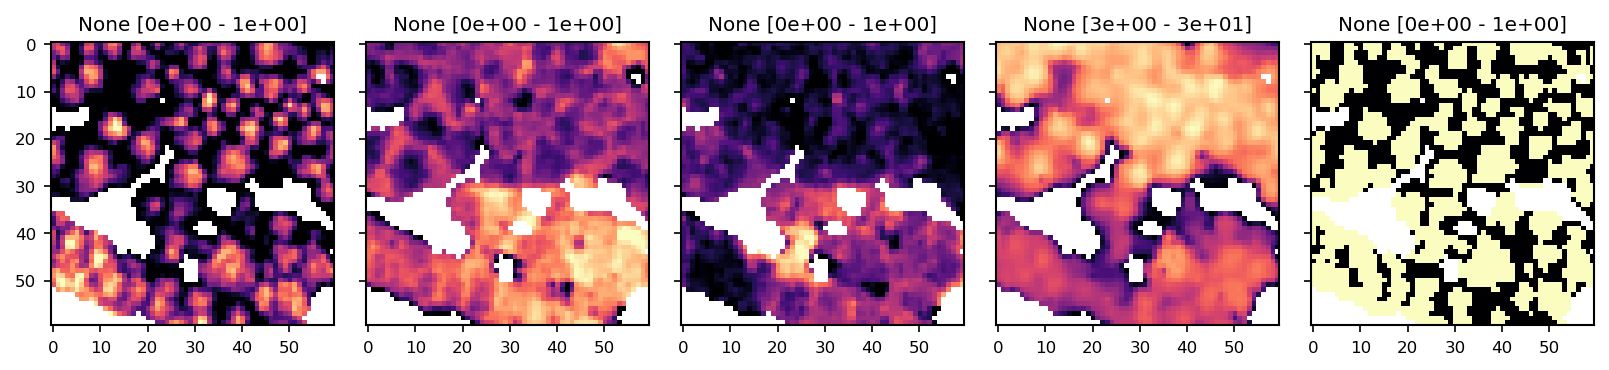

In [201]:
importlib.reload(visual)

channels = [
    cs_norm['l'], cs_norm['ndvi'], cs_norm['s'], cs_norm['z'], mask_local
]

xylim = [(200,30), (200,30)]
f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    mask=mask_global,
    zoom=0.7,
)

#### (4) Isolate connectedComponents within local mask

In [130]:
importlib.reload(segment2)

ccs_idx = segment2.connectedComponents_idx(mask_local.copy())
ccs_size = np.array([len(idx[0]) for idx in ccs_idx])
ccs_large_idx = np.where(ccs_size > 100)[0]

print(f"Median connectedComponent size: {np.percentile(ccs_size, 50):.0f}")
print(f"Maximum connectedComponent size: {np.percentile(ccs_size, 100):.0f}")

Median connectedComponent size: 16
Maximum connectedComponent size: 2132


758
8


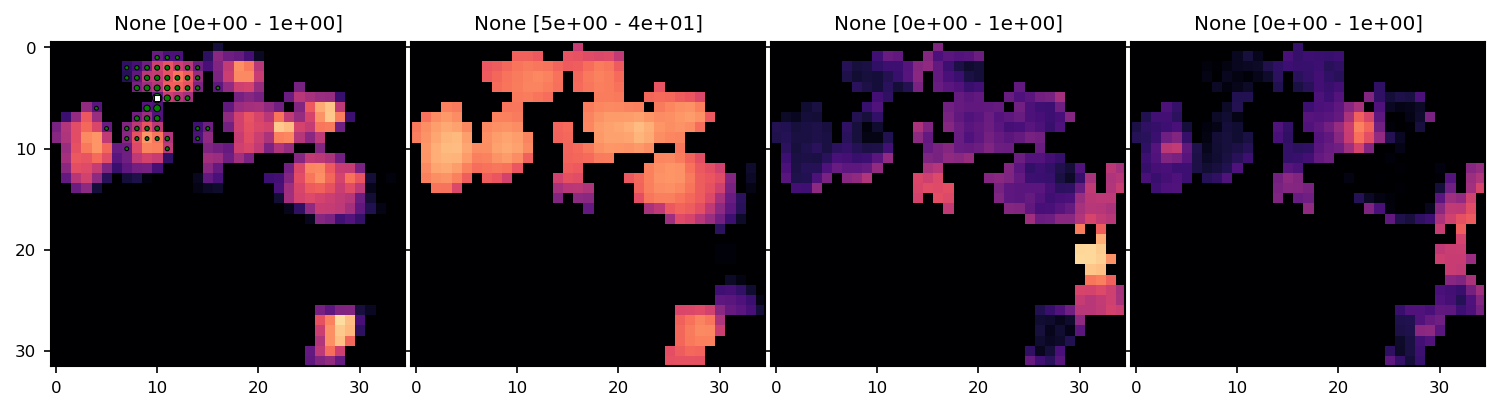

In [511]:
importlib.reload(segment2)
from scipy.spatial import distance_matrix

def cc_idx_tobox(idx):
    box_origin = (np.min(idx[0]), np.min(idx[1])) 
    
    box_width = (
        np.max(idx[0]) - np.min(idx[0]) + 1,
        np.max(idx[1]) - np.min(idx[1]) + 1,
    )

    box_idx = (
        idx[0].copy() - box_origin[0],
        idx[1].copy() - box_origin[1],
    )
    return box_idx, box_origin, box_width

def cc_img_tobox(idx, img):

    box_idx, box_origin, box_width = cc_idx_tobox(idx)
    
    box = np.zeros((box_width[0], box_width[1]), dtype=np.float32)
    box[box_idx] = img[idx]

    return box

def cc_toarray(idx, cs):
    
    # Init
    length = len(idx[0])
    data = np.zeros((length, 6), dtype=np.float32) # 3x spatial coordinates + 3x colors
    
    # Spatial coordinates
    data[:, 0] = cs['x'][idx]
    data[:, 1] = cs['y'][idx]
    data[:, 2] = cs['z'][idx]

    # Color channels
    data[:, 3] = cs['l'][idx]
    data[:, 4] = cs['ndvi'][idx]
    data[:, 5] = cs['s'][idx]

    return data

def cc_todistance(idx, cs, w=1):
    data = cc_toarray(idx, cs)
    dist_space = distance_matrix(data[:, :3], data[:, :3], p=2)
    dist_color = distance_matrix(data[:, 3:], data[:, 3:], p=100)

    dist = np.sqrt(dist_space**2 + w * dist_color**2)

    return data, dist

def nearestNeighbors_ball_inbox(idx, dist, r=10, i=None):

    if i is None:
        i = np.random.randint(0, len(idx[0]))
        print(i)

    box_idx = cc_idx_tobox(idx)[0]

    point = (box_idx[1][i], box_idx[0][i])
    
    nns_i = np.where(dist[i, :] <= r)[0]
    nns = np.zeros((len(nns_i), 3),)
    nns[:, 0] = box_idx[1][nns_i]
    nns[:, 1] = box_idx[0][nns_i]
    nns[:, 2] = dist[i, :][nns_i]

    return point , nns

########################
importlib.reload(visual)

i = ccs_large_idx[np.random.randint(0, len(ccs_large_idx))]
i = 758
print(i)
idx = ccs_idx[i]

l_box = cc_img_tobox(idx, cs_norm['l'])
chm_box = cc_img_tobox(idx, cs_norm['z'])
ndvi_box = cc_img_tobox(idx, cs_norm['ndvi'])
s_box = cc_img_tobox(idx, cs_norm['s'])

data, dists = cc_todistance(idx, cs_norm, w=10)
point, nns = nearestNeighbors_ball_inbox(idx, dists, r=5, i=8)

channels = [l_box, chm_box, ndvi_box, s_box]
contrasts = [(0,1), (5, 35), (0,1), (0,1)]

f, axs = visual.show_channels(
    channels, 
    contrasts=contrasts,
    zoom=0.8)


_ = axs[0].scatter(nns[:,0], nns[:,1], s = 20/(nns[:,2]+1), marker='o', fc='g', ec='k', lw=0.5)
_ = axs[0].scatter(point[0], point[1], s = 10, marker='s', fc='w', ec='k', lw=0.5)